In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import googlemaps
import gmplot

from dotenv import load_dotenv

from src.som import som

load_dotenv()
API_KEY = os.getenv('API_KEY')

In [2]:
gclient = googlemaps.Client(API_KEY)

In [3]:
with open('enderecos.txt', 'r') as f:
    enderecos = f.readlines()
    end_list = [texto.replace('\n', '') for texto in enderecos]

In [4]:
coordinates = []

lats = []
lgns = []

for end in end_list:
    geocode_result = gclient.geocode(end)
    coordinates.append(geocode_result[0]['geometry']['location'])
    
    lats.append(geocode_result[0]['geometry']['location']['lat'])
    lgns.append(geocode_result[0]['geometry']['location']['lng'])

In [5]:
df_coords = pd.DataFrame(coordinates)
df_coords.columns = ['x', 'y']
df_coords['codigo'] = df_coords.index

In [6]:
route = som(df_coords, 100000, 'teste')

Network of 56 neurons created. Starting the iterations:
Radius has completely decayed, finishing execution at 13415 iterations


In [7]:
route

Int64Index([0, 4, 5, 6, 3, 2, 1], dtype='int64')

In [8]:
start = 0
lst_route = list(route)

idx = lst_route.index(start)

last = lst_route[idx:]
first = lst_route[:idx]

final = last + first

In [20]:
location_list = []
for i, (_, row) in enumerate(df_coords.iloc[final].iterrows()):
    if i == 0 :
        start = (row['x'], row['y'])
    # elif i == len(df_coords) - 1:
    #     end = (row['x'], row['y'])
    else:
        location_list.append((row['x'], row['y']))

gmap = gmplot.GoogleMapPlotter(
    np.mean(lats),
    np.mean(lgns),
    13,
    apikey=API_KEY
)

gmap.scatter(lats, lgns, color='red')

gmap.directions(
    start,
    start,
    waypoints=location_list
)

location_list.insert(0, start)

for i, location in enumerate(location_list):
    if i == 0:
        gmap.text(location[0], location[1], 'Start', color='blue')
    else:
        gmap.text(location[0], location[1], f'______{i+1}')


gmap.draw('maps/map.html')

In [21]:
distance = 0
time = 0

for i in range(len(location_list) - 1):
    response = gclient.distance_matrix(location_list[i], location_list[i+1])
    
    distance += response['rows'][0]['elements'][0]['distance']['value']
    time += response['rows'][0]['elements'][0]['duration']['value']
    

Distância (km): 8.708
Tempo estimado do trajeto (min): 24.6


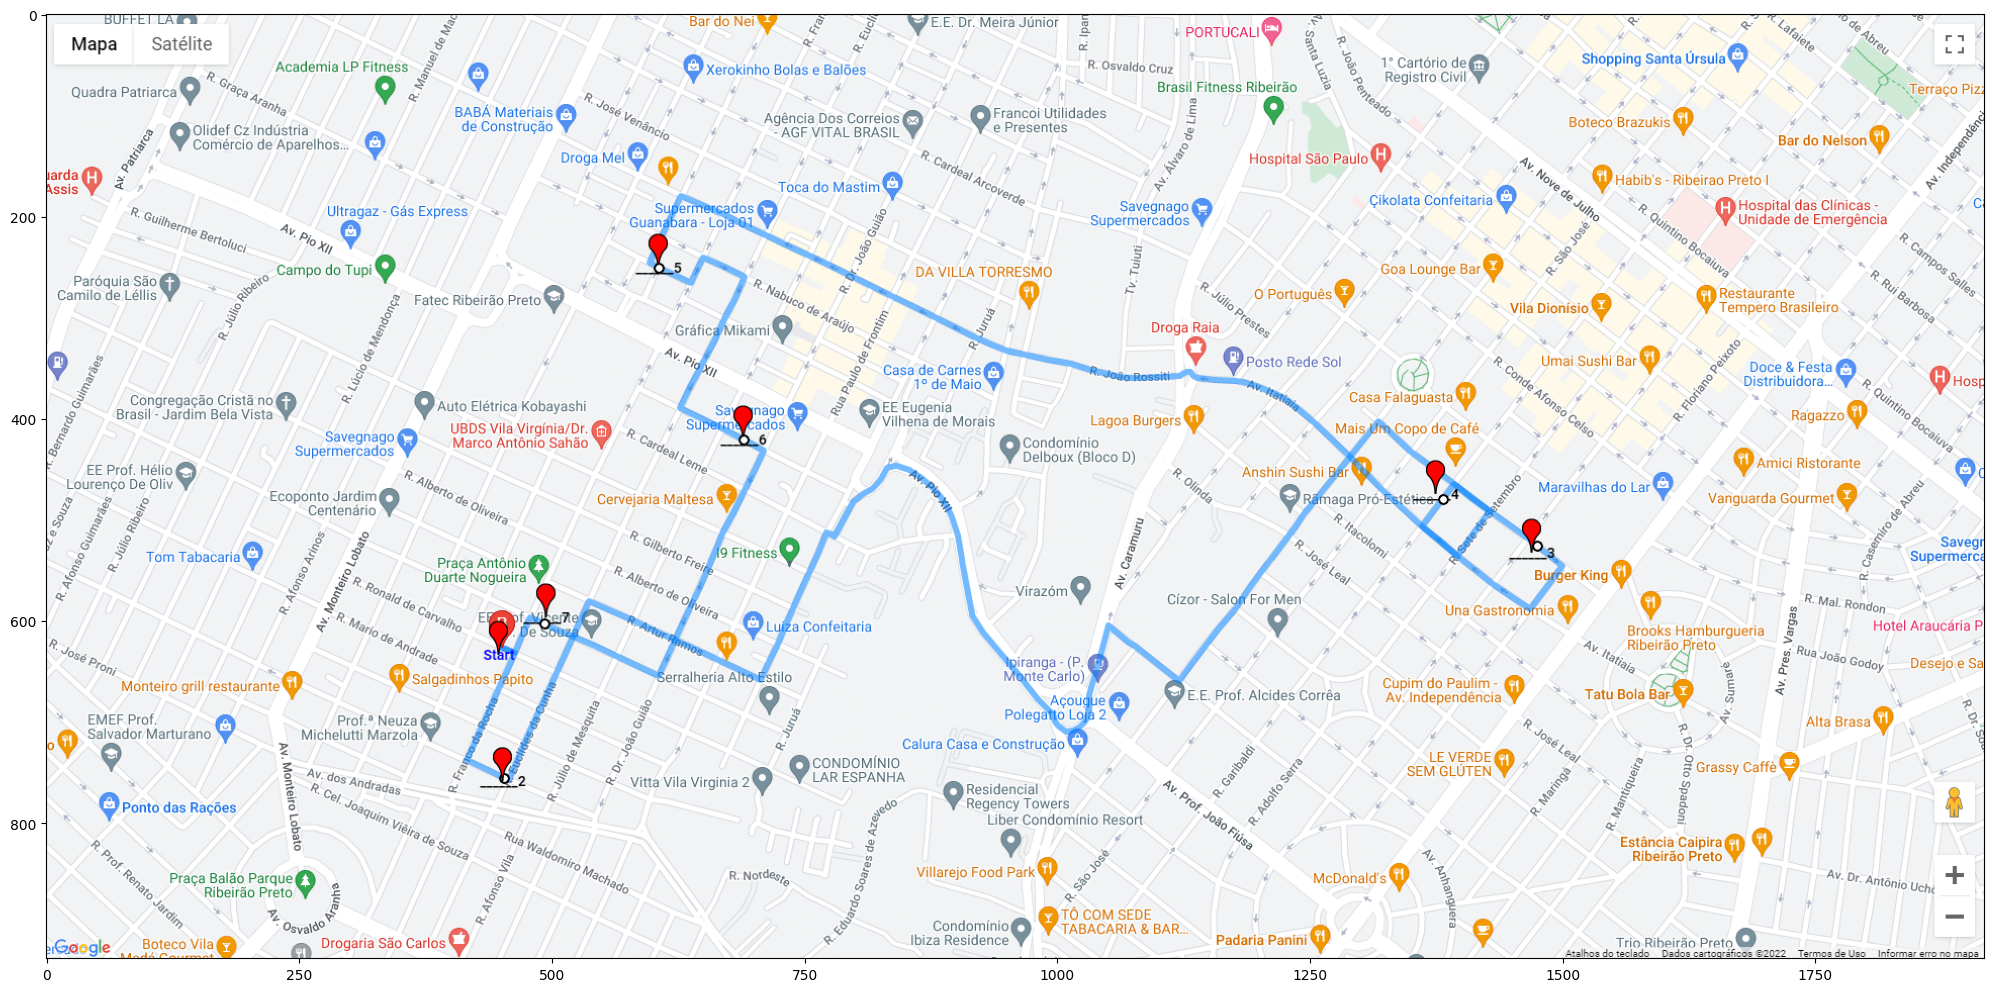

In [24]:
print(f"Distância (km): {distance / 1000}")
print(f"Tempo estimado do trajeto (min): {time / 60}")

mapa = plt.imread('mapa.png')

plt.figure(figsize=(25,25))
plt.imshow(mapa)
plt.show()